### Grading
The final score that you will receive for your programming assignment is generated in relation to the total points set in your programming assignment item—not the total point value in the nbgrader notebook.

When calculating the final score shown to learners, the programming assignment takes the percentage of earned points vs. the total points provided by nbgrader and returns a score matching the equivalent percentage of the point value for the programming assignment.

**DO NOT CHANGE VARIABLE OR METHOD SIGNATURES.** The autograder will not work properly if your change the variable or method signatures. 

### WARNING
Please refrain from using **print statements/anything that dumps large outputs(>500 lines) to STDOUT** to avoid running to into **memory issues**. 
Doing so requires your entire lab to be reset which may also result in loss of progress and you will be required to reach out to Coursera for assistance with this.
This process usually takes time causing delays to your submission.

### Validate Button
Please note that this assignment uses nbgrader to facilitate grading. You will see a **validate button** at the top of your Jupyter notebook. If you hit this button, it will run tests cases for the lab that aren't hidden. It is good to use the validate button before submitting the lab. Do know that the labs in the course contain hidden test cases. The validate button will not let you know whether these test cases pass. After submitting your lab, you can see more information about these hidden test cases in the Grader Output. <br>

***Cells with longer execution times will cause the validate button to time out and freeze. Please know that if you run into Validate time-outs, it will not affect the final submission grading.*** <br>

# Homework 6: Support Vector Machines 
***

In this assignment we'll explore the details of the Soft-Margin SVM and look at how the choice of tuning parameters  affects the learned models.  We'll also look at kernel SVMs for non-linearly separable and methods for choosing and visualizing good hyperparameters.   

**Note**: Below are some helper functions which are used throughout this notebook.  Execute these before continuing. Do not modify.

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
%matplotlib inline

def linear_plot(X, y, w=None, b=None):
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    
    # Plot data 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.scatter(X[:,0], X[:,1], color=colors, s=150, alpha=0.95, zorder=2)
    
    # Plot boundaries 
    lower_left = np.min([np.min(X[:,0]), np.min(X[:,1])])
    upper_right = np.max([np.max(X[:,0]), np.max(X[:,1])])
    gap = .1*(upper_right-lower_left)
    xplot = np.linspace(lower_left-gap, upper_right+gap, 20)
    if w is not None and b is not None: 
        ax.plot(xplot, (-b - w[0]*xplot)/w[1], color="gray", lw=2, zorder=1)
        ax.plot(xplot, ( 1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        ax.plot(xplot, (-1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        
    
    ax.set_xlim([lower_left-gap, upper_right+gap])
    ax.set_ylim([lower_left-gap, upper_right+gap])
    
    ax.grid(alpha=0.25)
    
def part2data():
    
    np.random.seed(1239)
    
    X = np.zeros((22,2))
    X[0:10,0]  = 1.5*np.random.rand(10) 
    X[0:10,1]  = 1.5*np.random.rand(10)
    X[10:20,0] = 1.5*np.random.rand(10) +  1.75
    X[10:20,1] = 1.5*np.random.rand(10) +  1
    X[20,0] = 1.5
    X[20,1] = 2.25
    X[21,0] = 1.6
    X[21,1] = 0.25
    
    y = np.ones(22)
    y[10:20] = -1 
    y[20] = 1
    y[21] = -1
    
    return X, y

def part3data(N=100, seed=1235):
    
    np.random.seed(seed)
    
    X = np.random.uniform(-1,1,(N,2))
    y = np.array([1 if y-x > 0 else -1 for (x,y) in zip(X[:,0]**2 * np.sin(2*np.pi*X[:,0]), X[:,1])])
    X = X + np.random.normal(0,.1,(N,2))
    
    return X, y

def nonlinear_plot(X, y, clf=None): 
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    ax.scatter(X[:,0],X[:,1], marker='o', color=colors, s=100, alpha=0.5)
    
    ax.arrow(-1.25,0,2.5,0, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    ax.arrow(0,-1.25,0,2.5, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    z = np.linspace(0.25,3.5,10)
    
    ax.set_xlim([-1.50,1.50])
    ax.set_ylim([-1.50,1.50])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([], fontsize=16)
    plt.yticks([], fontsize=16)
    

    if clf: 
        
        clf.fit(X,y)

        x_min = X[:, 0].min()+.00
        x_max = X[:, 0].max()-.00
        y_min = X[:, 1].min()+.00
        y_max = X[:, 1].max()-.00

        colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.contour(XX, YY, Z, colors=[mycolors["blue"], "gray", mycolors["red"]], linestyles=['--', '-', '--'],
                    levels=[-1.0, 0, 1.0], linewidths=[2,2,2], alpha=0.9)
    

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")

### Part 1: SVM [20 pts, Peer Review]

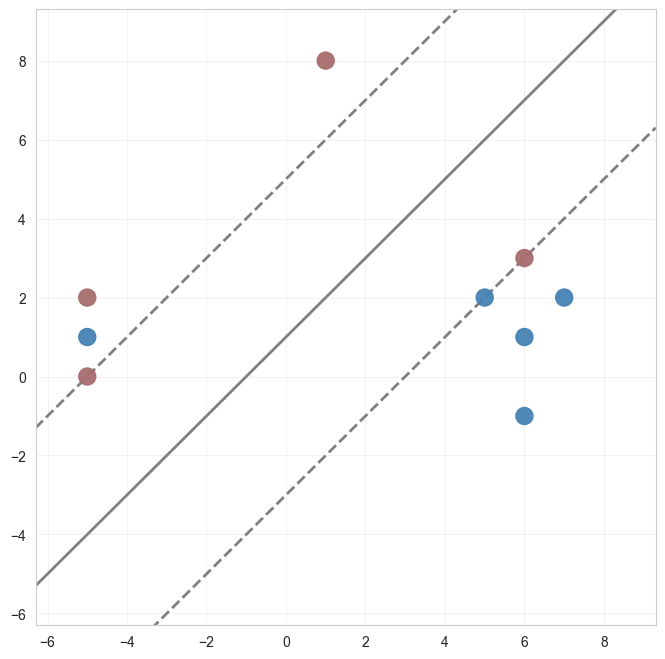

In [3]:
import numpy as np

# Data and Labels 
X = np.array([[1,8],[7,2],[6,-1],[-5,0], [-5,1], [-5,2],[6,3],[6,1],[5,2]])
y = np.array([1,-1,-1,1,-1,1,1,-1,-1])

# Support vector parameters 
w, b = np.array([-1/4, 1/4]), -1/4

# Plot the data and support vector boundaries 
linear_plot(X, y, w=w, b=b)

**Part A [5 pts]**: What is the margin of this particular SVM? 

In [4]:
# update margin to be a correct number
# For a linear SVM, margin = 1 / L2 norm(w)
norm_w = np.linalg.norm(w)
margin = 1 / norm_w
print(f"Margin = 1 / ||w|| = {margin:.4f}")

Margin = 1 / ||w|| = 2.8284


In [5]:
# tests that margin was updated correctly

**Part B [5 pts, Peer Review]**: Which training examples are the support vectors? Assign the coordinate in the list. e.g. support_vectors = [(1,0),(0,0)]

In [6]:
# First define the margins
margins = y * (np.dot(X, w) + b)
# then determine which category each point belongs to
in_bound =X[margins ==1]
out_bound =X[margins < 1]
not_support = X[margins > 1]
print(f'The in-bound support vectors (lies on the margin) are: \n{in_bound}')
print(f'The out-bound support vecctors (violates the margin) are: \n{out_bound}')
print(f'The points that do not form part of the support vector are: \n{not_support}')
# finally, concatenate in-bound and out-bound to create a list of all support vectors
support_vectors = np.concatenate((in_bound, out_bound)).tolist()
# not sure why the question asks for a list of tuples, but it does, so:
support_vectors = [tuple(v) for v in support_vectors]
print(f'The full set of support_vectors is: \n{support_vectors}')

The in-bound support vectors (lies on the margin) are: 
[[-5  0]
 [ 5  2]]
The out-bound support vecctors (violates the margin) are: 
[[-5  1]
 [ 6  3]]
The points that do not form part of the support vector are: 
[[ 1  8]
 [ 7  2]
 [ 6 -1]
 [-5  2]
 [ 6  1]]
The full set of support_vectors is: 
[(-5, 0), (5, 2), (-5, 1), (6, 3)]


In [7]:
# tests support_vectors

Answer the following question in this week's **Peer Review assignment**:<br> 
Explain your answer for which training examples are support vectors. For the support vectors that you have identified, which are the in-bound support vectors and which are the out-bound support vectors? 

In [8]:
# instructor testing cell 
# your code here


**Part C [5 pts, Peer Review]**: Which training examples have nonzero slack? List their coordinates.

In [9]:
# list of coordinates with nonzero slack. I.e. margin < 1
nonzero_slack = X[margins < 1].tolist()
nonzero_slack = [tuple(v) for v in nonzero_slack]
print(nonzero_slack)

[(-5, 1), (6, 3)]


In [10]:
# tests nonzero_slack list 

Answer the following question in this week's **Peer Review assignment**: <br>
How did you know which training examples had nonzero slack? 

In [11]:
# instructor testing cell
# your code here


**Part D [5 pts, Peer Review]**: Compute the slack $\xi_i$ associated with the misclassified points. 

Slack Formula:
#### ξ<sub>i</sub> = 1 −  y<sub>i</sub> ( w<sup>T</sup> x<sub>i</sub>  + b )


In [12]:
# compute the slack associated with the misclassified points
# return a list slacks with the slack computations
slacks = np.maximum(0, 1-margins)
slacks = slacks[slacks > 0]
slack1 = slacks[0]
slack2 = slacks[1]
print(f'The slack for point {nonzero_slack[0]} is {slack1} and point {nonzero_slack[1]} is {slack2}')

The slack for point (-5, 1) is 2.25 and point (6, 3) is 2.0


In [13]:
# tests slacks

Answer the following question in your **Peer Review assignment for the week**: <br>
Do these slack values agree with the plot of the data and the support vector boundaries? 

### Part 2: The Margin vs Slack 
***

In this problem we'll figure out how to fit linear SVM models to data using sklearn.  Consider the data shown below.

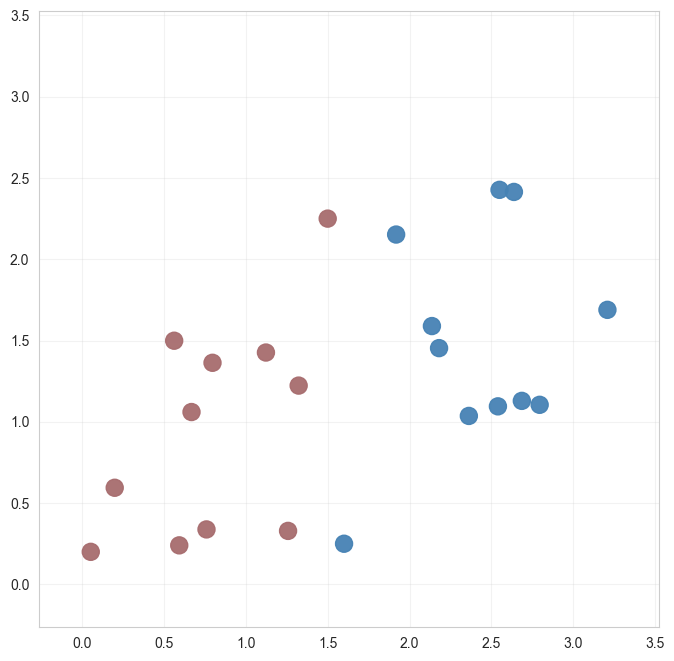

In [14]:
X, y = part2data()
linear_plot(X, y)

**Part A [5 pts]**: Let's fit a linear Soft-Margin SVM to the data above. For SVMs with a linear kernel we'll use the [`LinearSVM`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) method from sklearn's `svm` module.  Go now and look at the documentation. 

Recall that the primal objective function for the linear kernel SVM is as follows 


$$
\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2}\|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i^p.
$$
**Note that the C parameter definition in sklearn is different from the textbook.**

The two optional parameters in `LinearSVM` that we'll be most concerned with are `C`, the hyperparameter weighting the slackness contribution to the primal objective function, and `loss`, which determines the exponent on the slack variables in the sum. When $p=1$ from above equation, the loss is hinge loss, whereas is $p=2$, it's $L2$ form, the loss is called squared-hinge.

Write some code below to train a linear SVM with $C=1$ and $p=1$, get the computed weight vector and bias, and the plot the resulting model.

[-1.41897528  0.30584252] [1.76759606]


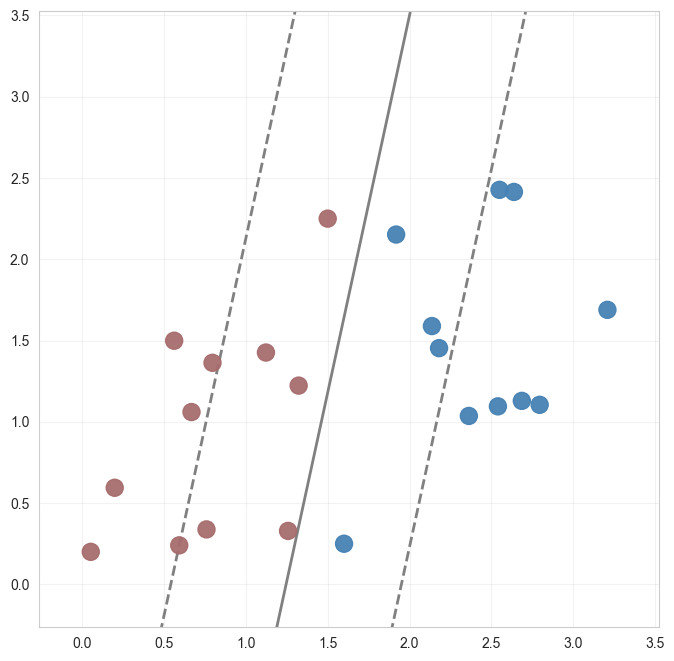

In [15]:
from sklearn.svm import LinearSVC

lsvm = LinearSVC(C=1, loss='hinge', random_state=0, tol=1e-5)
lsvm.fit(X, y)

# use this code to plot the resulting model
w = lsvm.coef_[0]
b = lsvm.intercept_
print(w,b)
linear_plot(X, y, w=w, b=b)

In [16]:
# tests w and b 

**Part B**: Experiment with different values of `C`.  Answer the following question in your Peer Review for the week: How does the choice of `C` affect the nature of the decision boundary and the associated margin? 


C=0.3 => w: [-0.86121866  0.1994082 ], b: 1.0405987135129031


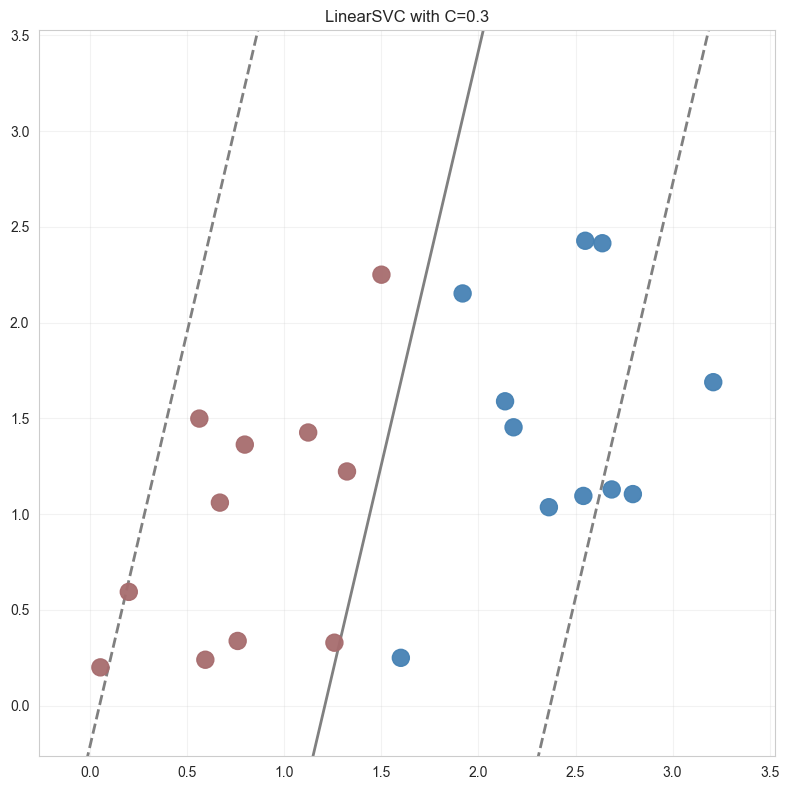


C=1 => w: [-1.22506799  0.2774433 ], b: 1.564302631932783


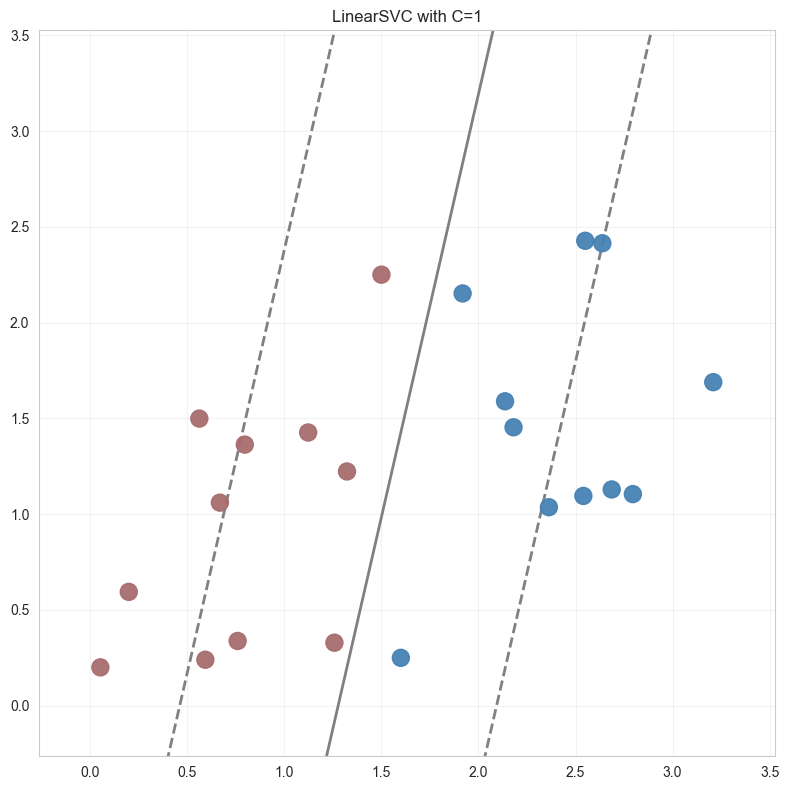


C=3 => w: [-1.73395306  0.3818146 ], b: 2.269432632644997


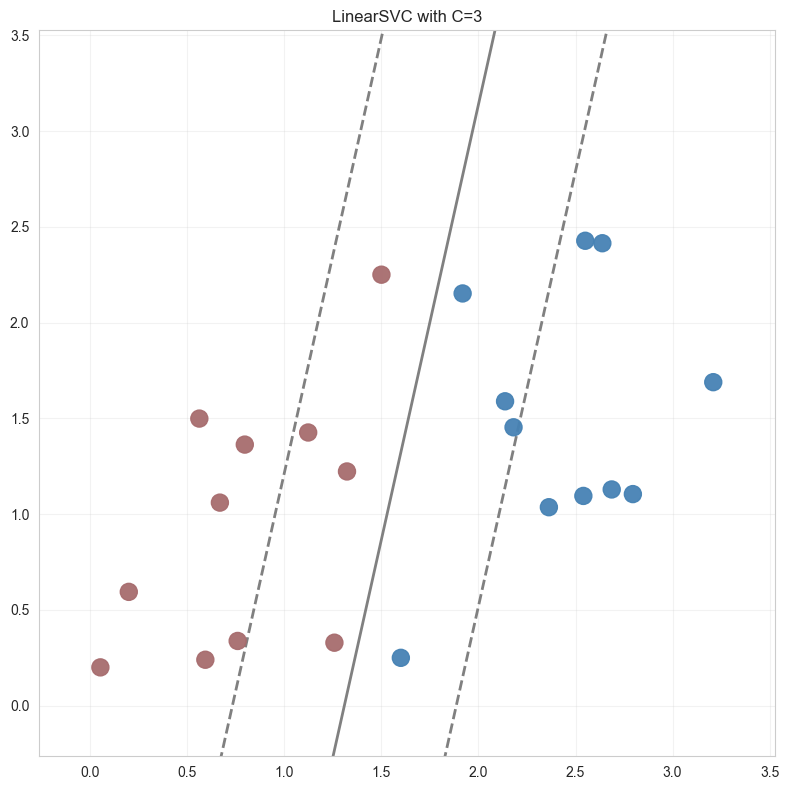


C=10 => w: [-2.83008621  0.49308764], b: 3.850613073496216


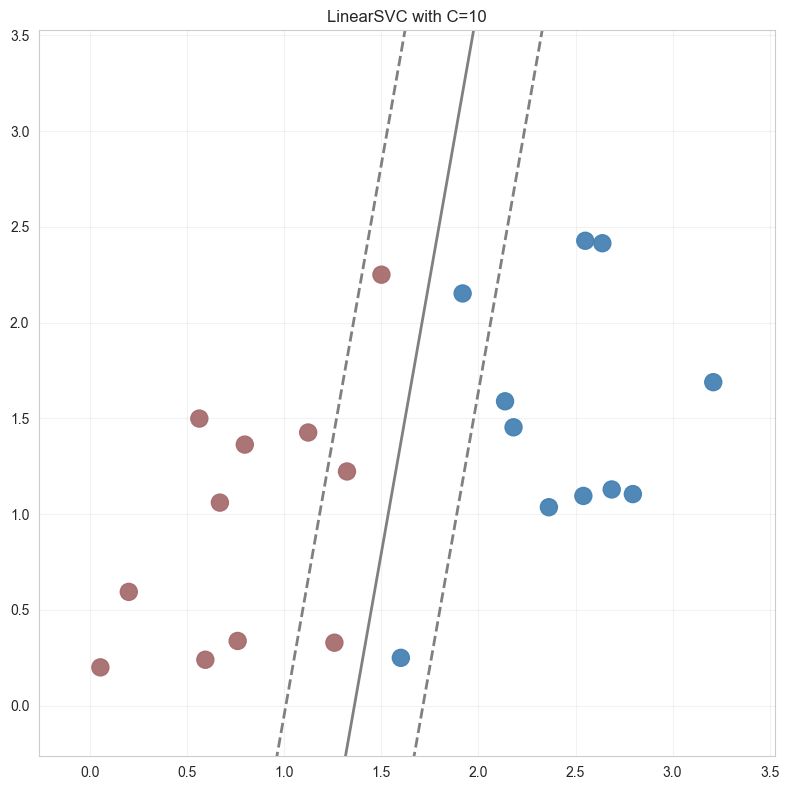

In [17]:
C_values = [0.3, 1, 3, 10]

for i, C in enumerate(C_values):
    # Train the LinearSVC model with the current C value
    lsvm = LinearSVC(C=C, random_state=0, tol=1e-5)
    lsvm.fit(X, y)

    # Extract weights and bias
    w = lsvm.coef_[0]
    b = lsvm.intercept_[0]

    print(f"\nC={C} => w: {w}, b: {b}")
    linear_plot(X, y, w=w, b=b)
    plt.title(f"LinearSVC with C={C}")
    plt.tight_layout()
    plt.show()


**Part C**: Set `C=3` and compare the results you get when using the `hinge` vs the `squared_hinge` values for the `loss` parameter.  In this week's Peer Review Assignment: Explain your observations. Compare hinge loss vs. squared hinge loss.  


C=C, loss=hinge => w: [-2.22816236  0.85516937], b: 2.4025932838037645


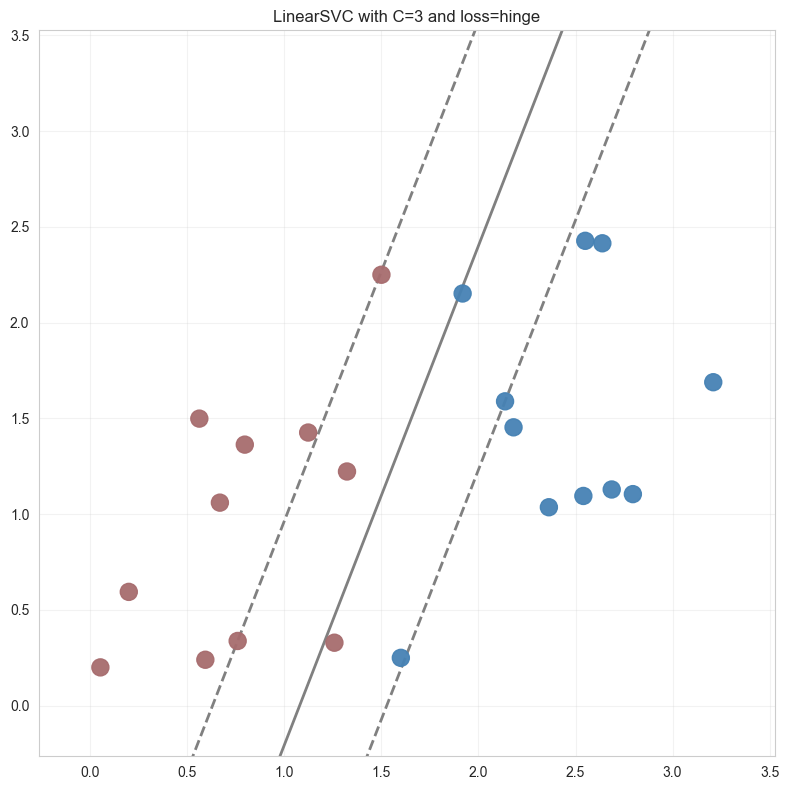


C=C, loss=squared_hinge => w: [-1.73395306  0.3818146 ], b: 2.269432632644997


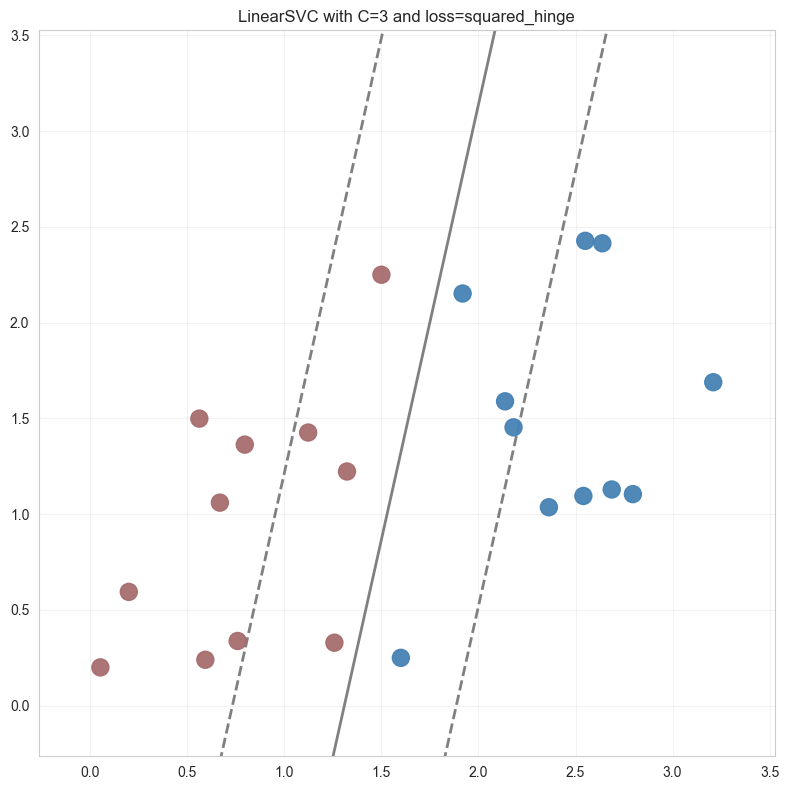

In [18]:
loss_parameters = ['hinge', 'squared_hinge']
C = 3
for i, lp in enumerate(loss_parameters):
    # Train the LinearSVC model with the current C value
    lsvm = LinearSVC(C=C, loss = lp, random_state=0, tol=1e-5)
    lsvm.fit(X, y)

    # Extract weights and bias
    w = lsvm.coef_[0]
    b = lsvm.intercept_[0]

    print(f"\nC=C, loss={lp} => w: {w}, b: {b}")
    linear_plot(X, y, w=w, b=b)
    plt.title(f"LinearSVC with C={C} and loss={lp}")
    plt.tight_layout()
    plt.show()



**Part D**: In general, how does the choice of `C` affect the bias and variance of the model? Write your answer in this week's Peer Review assignment. 

In [19]:
# testing cell 
# your code here


### Part 3: Nonlinear SVM, Parameter Tuning, Accuracy, and Cross-Validation 
***

Any support vector machine classifier will have at least one parameter that needs to be tuned based on the training data.  The guaranteed parameter is the $C$ associated with the slack variables in the primal objective function, i.e. 

$$
\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2}\|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i
$$

If you use a kernel fancier than the linear kernel then you will likely have other parameters as well. For instance in the polynomial kernel $K({\bf x}, {\bf z}) = ({\bf x}^T{\bf z} + c)^d$ you have to select the shift $c$ and the polynomial degree $d$.  Similarly the rbf kernel

$$
K({\bf x}, {\bf z}) = \exp\left[-\gamma\|{\bf x} - {\bf z}\|^2\right]
$$

has one tuning parameter, namely $\gamma$, which controls how fast the similarity measure drops off with distance between ${\bf x}$ and ${\bf z}$. 

For our examples we'll consider the rbf kernel, which gives us two parameters to tune, namely $C$ and $\gamma$. 

Consider the following two dimensional data

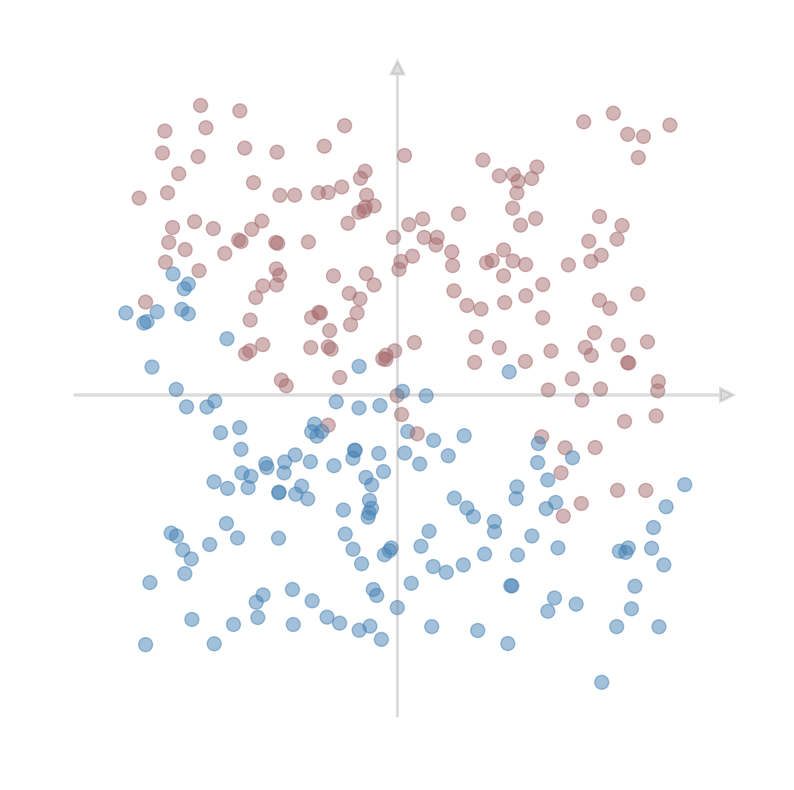

In [20]:
X, y = part3data(N=300, seed=1235)
nonlinear_plot(X, y)

**Part A**: We can use the method [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) from sklearn's `svm` module to fit an SVM with a nonlinear kernel to the data.  Go now and look at the documentation. Note that we pass the `kernel="rbr"` parameter to use the RBF kernel.  The other two parameters we'll be concerned with are `C` and the RBF parameter `gamma`.   

Write some code to fit an SVM with RBF kernel to the data and plot the results.  Use the parameter values `C=1` and `gamma=1`.

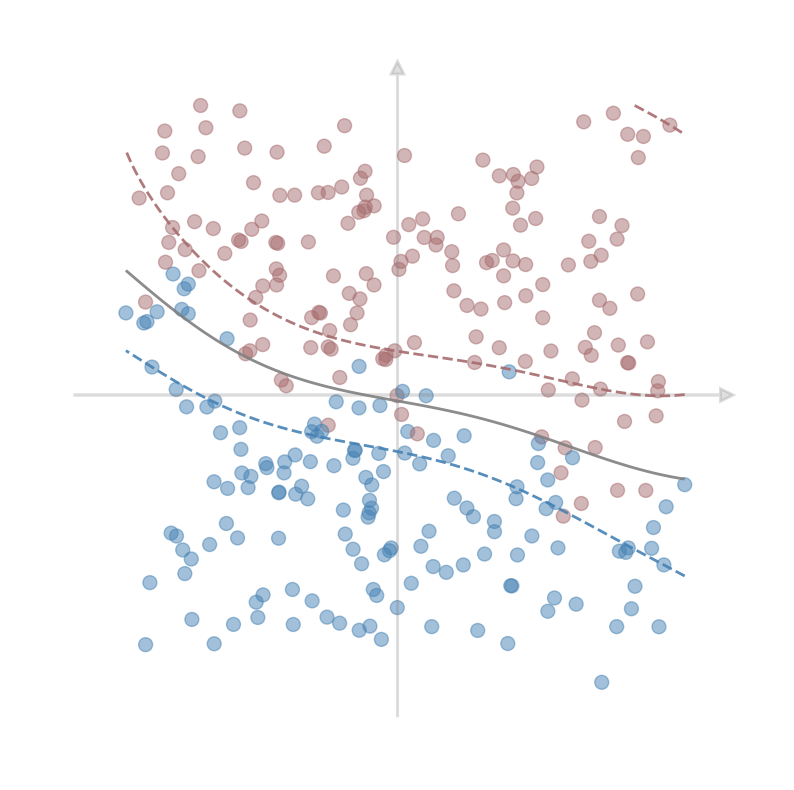

In [21]:
from sklearn.svm import SVC

nlsvm = SVC(kernel='rbf', C=1, gamma=1)
nlsvm.fit(X, y)
nonlinear_plot(X, y, nlsvm)

**Part B**: In this part we'll use cross-validation to estimate the validation accuracy achieved by our model.  Experiment with the values of the hyperparameters to see if you can get a good validation accuracy. How do the choice of `C` and `gamma` affect the resulting decision boundary? Write your response in this week's Peer Review assignment. 

For C = 1 and gamma = 1, cross-val mean-accuracy: 0.92


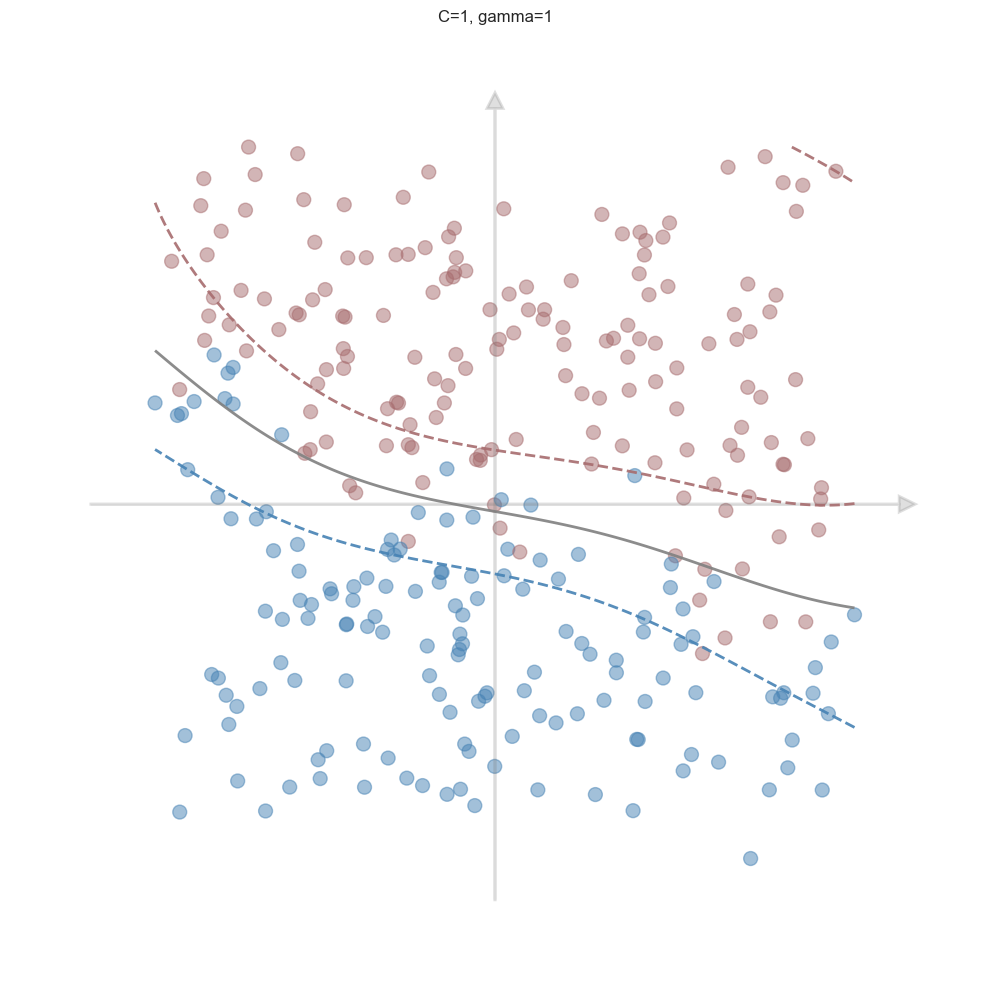

For C = 3 and gamma = 1, cross-val mean-accuracy: 0.923


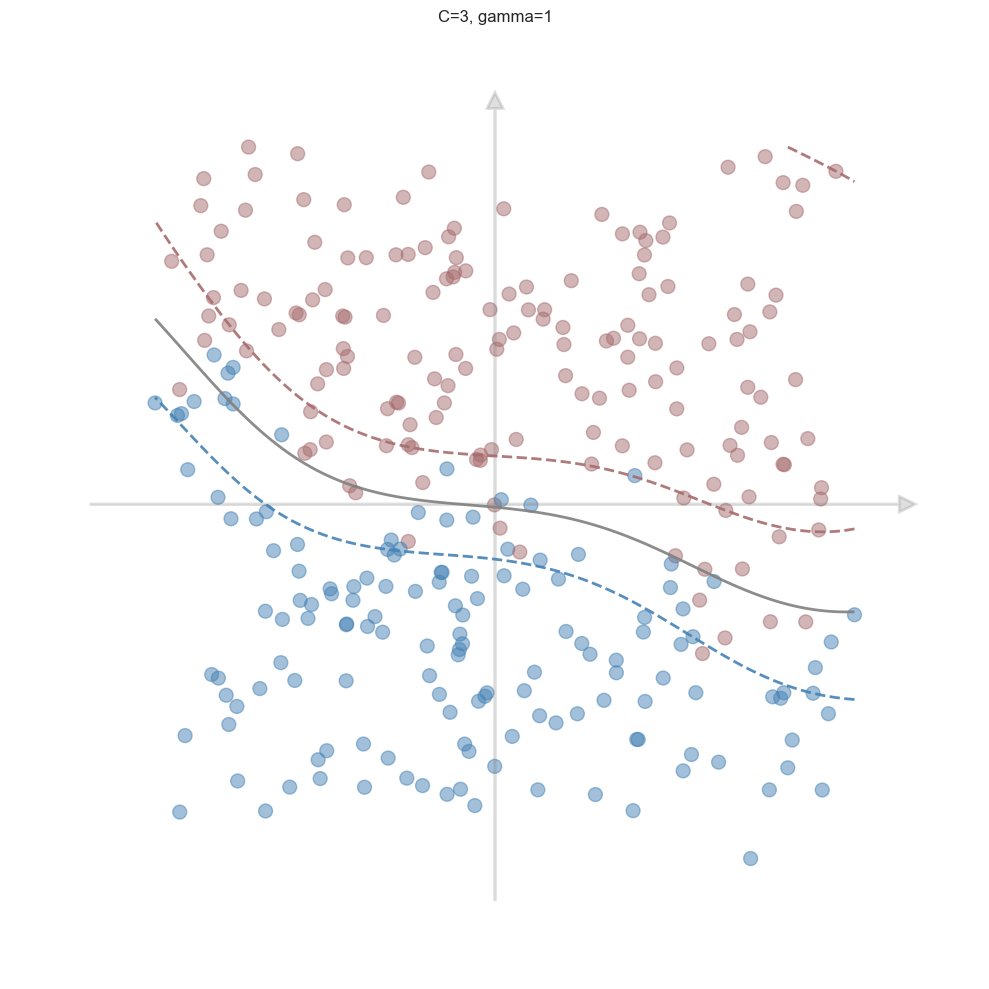

For C = 10 and gamma = 1, cross-val mean-accuracy: 0.933


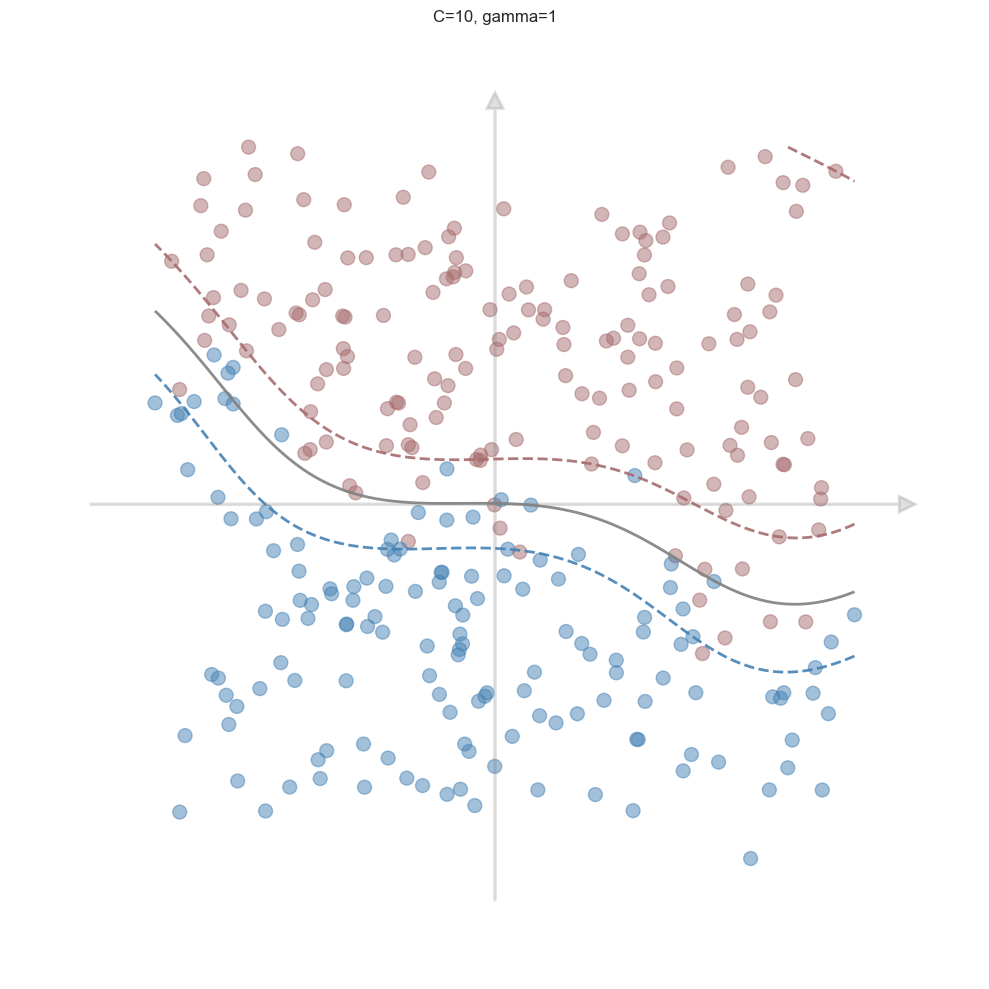

For C = 15 and gamma = 1, cross-val mean-accuracy: 0.927


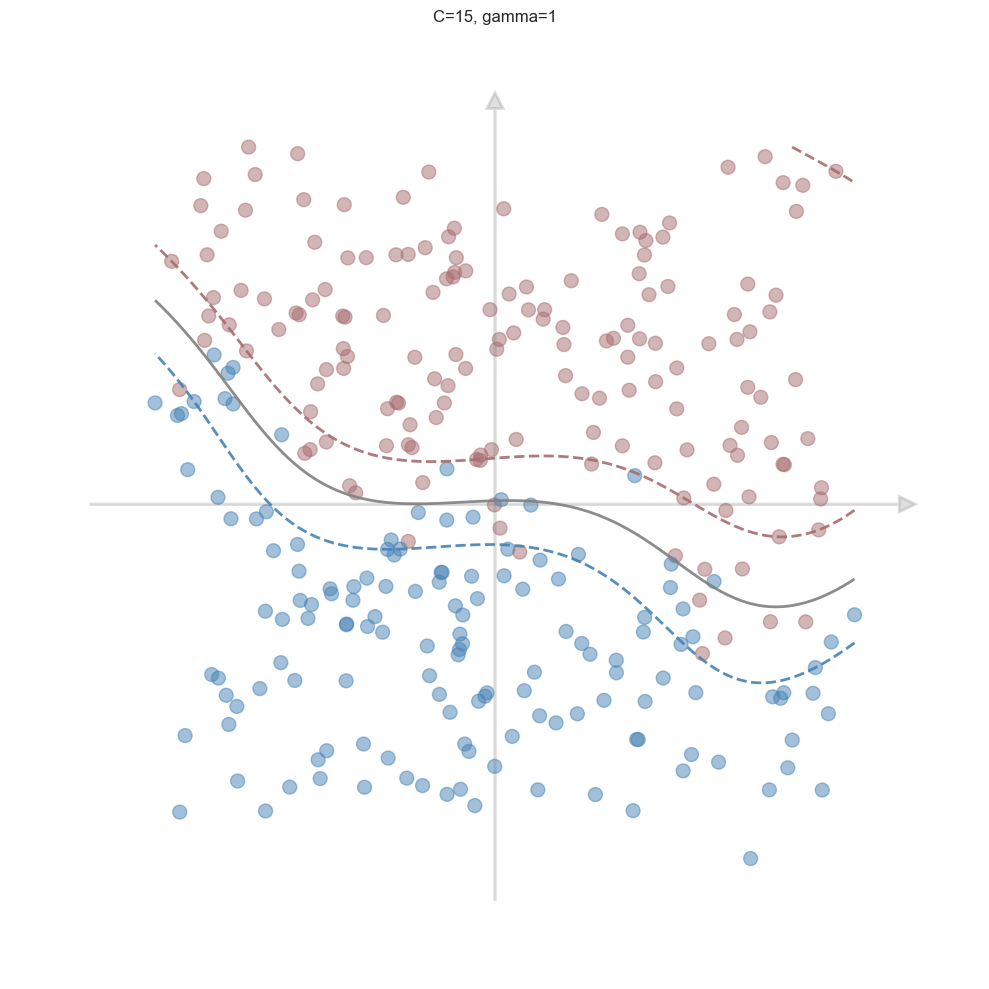

For C = 10 and gamma = 1, cross-val mean-accuracy: 0.933


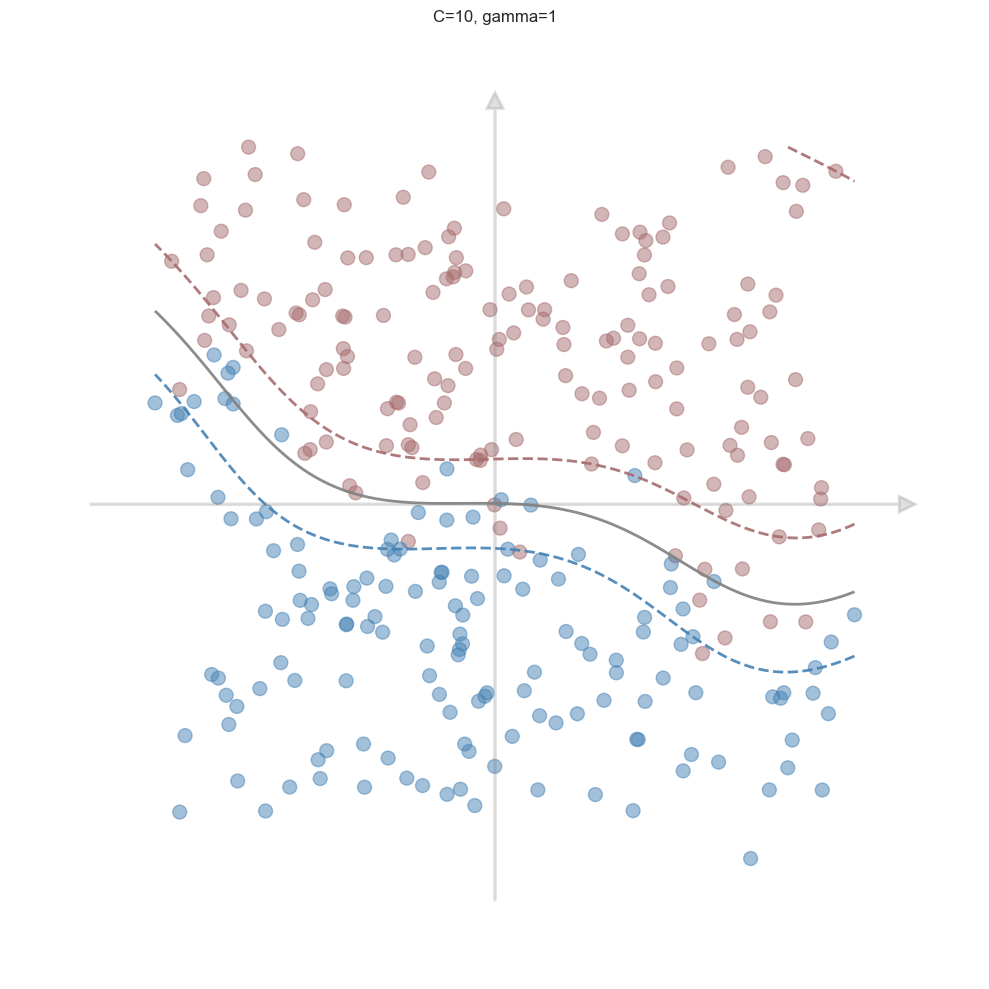

For C = 10 and gamma = 3, cross-val mean-accuracy: 0.937


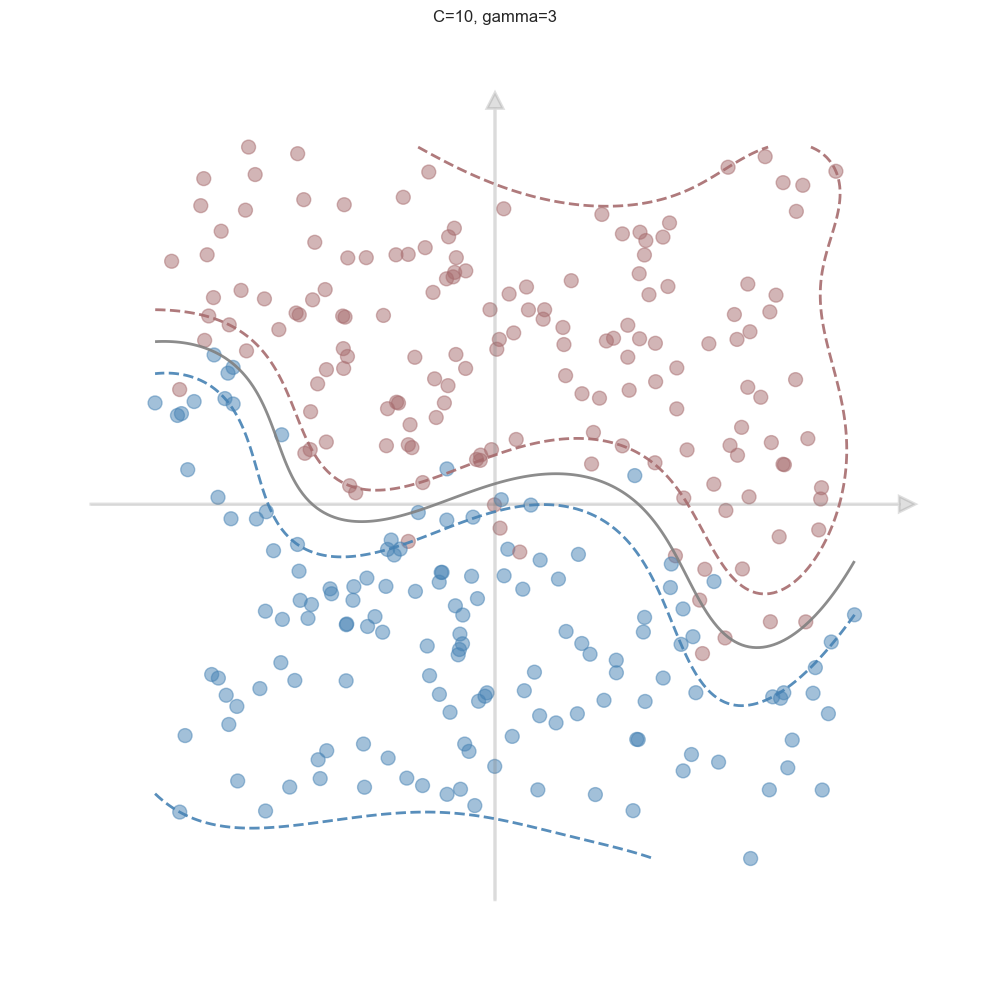

For C = 10 and gamma = 10, cross-val mean-accuracy: 0.943


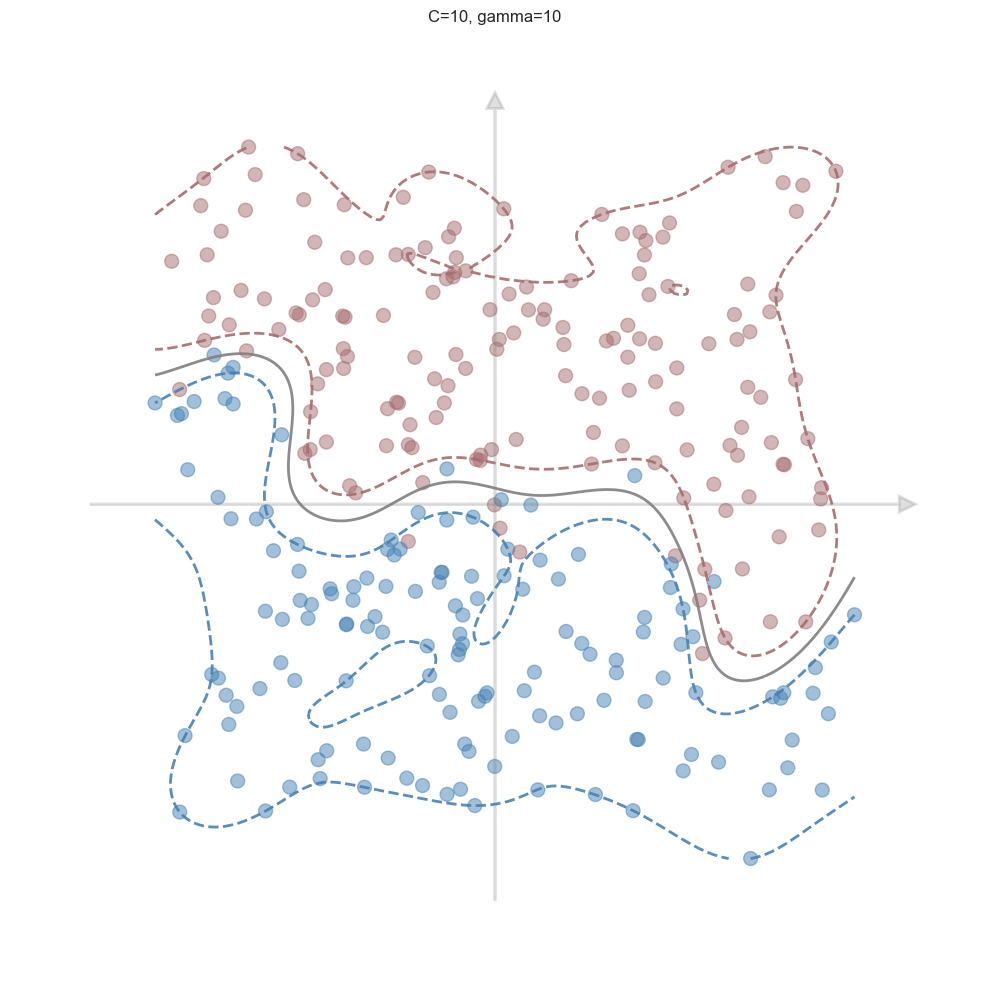

For C = 10 and gamma = 12, cross-val mean-accuracy: 0.94


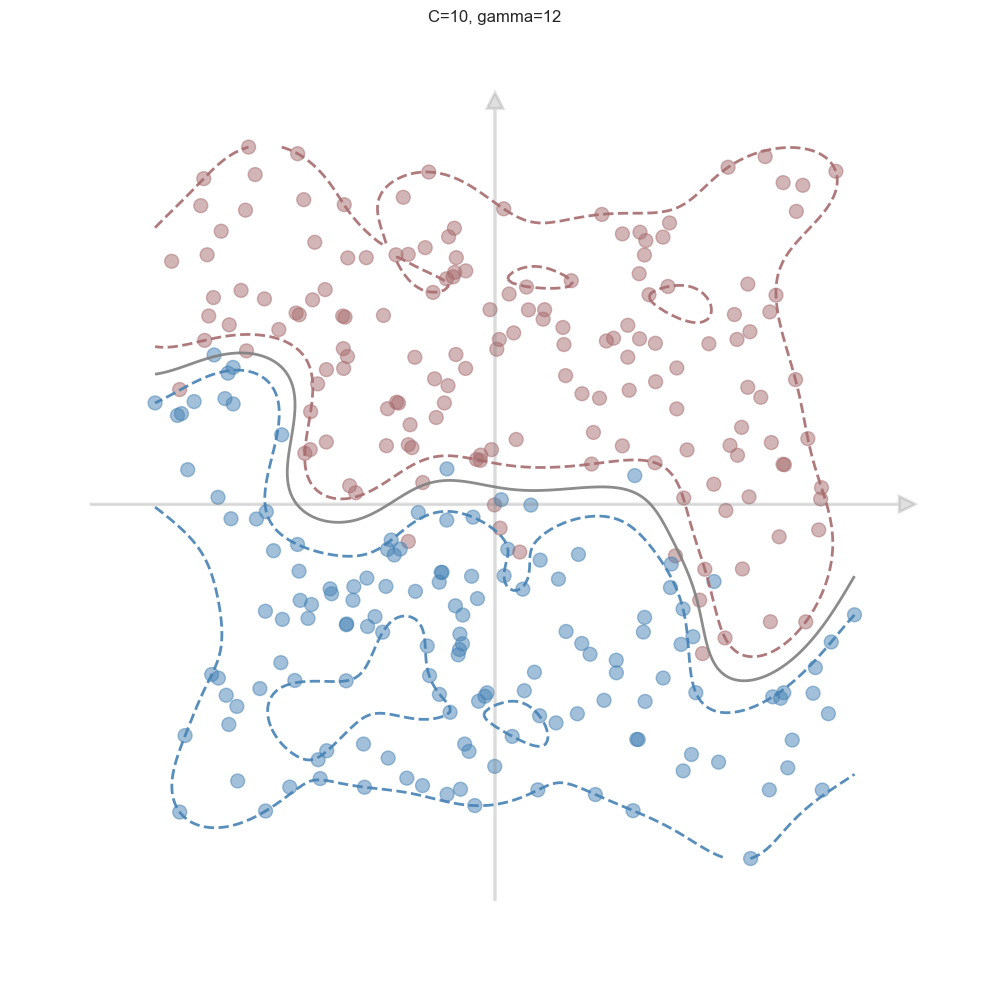

Best C=10, gamma=10


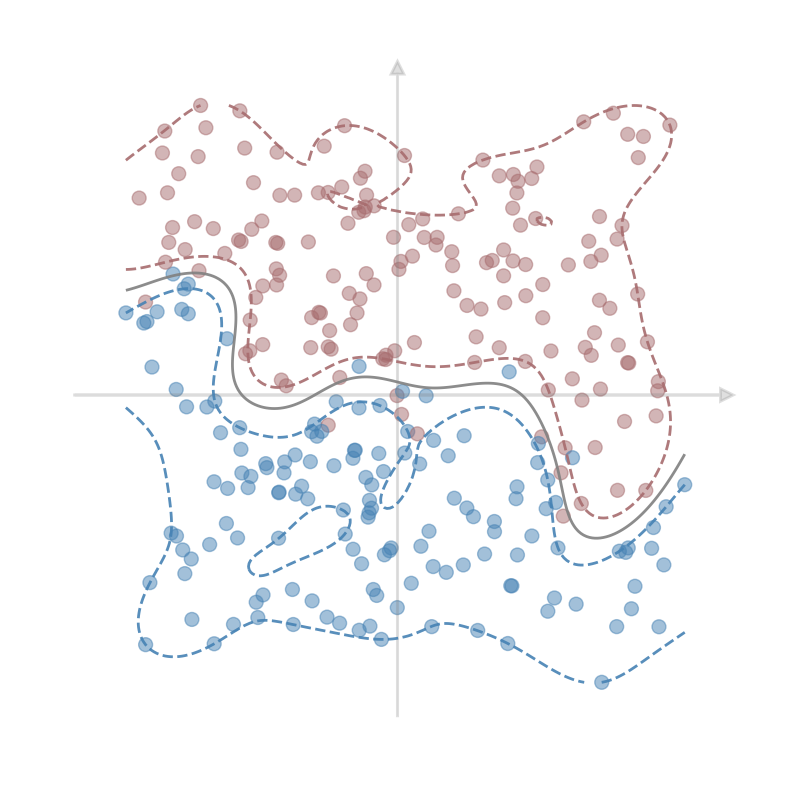

In [22]:
from sklearn.model_selection import cross_val_score

def cv_score_model(X, y, C=1, gamma=1):
    nlsvm = SVC(kernel='rbf', C=C, gamma=gamma)
    scores=cross_val_score(nlsvm, X, y, cv=5, n_jobs=1)
    score=np.mean(scores)
    print(f'For C = {C} and gamma = {gamma}, cross-val mean-accuracy: {round(score,3)}')
    nonlinear_plot(X, y, nlsvm)
    plt.title(f"C={C}, gamma={gamma}")
    plt.tight_layout()
    plt.show()
    return score

# C tuning
C_values = [1, 3, 10, 15]
c_scores = {}
for i, C in enumerate(C_values):
    c_scores[C] = cv_score_model(X, y, C=C, gamma=1)
best_C = max(c_scores, key=c_scores.get)

# gamma tuning
gamma_values = [1, 3, 10, 12]
gamma_scores = {}
for i, gamma in enumerate(gamma_values):
    gamma_scores[gamma] = cv_score_model(X, y, C=best_C, gamma=gamma)
best_gamma = max(gamma_scores, key=gamma_scores.get)

print(f'Best C={best_C}, gamma={best_gamma}')
nlsvm = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
nonlinear_plot(X, y, nlsvm)


**Part C**: How does the choice of **kernel** function affect the bias/variance of the model? Write your answer in this week's Peer Review assignment.   

In [23]:
# instructor testing cell 
# your code here


### Part 4: Automating the Parameter Search 
***

On the previous problem we were able to choose some OK parameters just by hand-tuning.  But in real life (where time is money) it would be better to do something a little more automated.  One common thing to do is a **grid-search** over a predefined range of the parameters.  In this case you will loop over all possible combinations of parameters, estimate the accuracy of your model using K-Folds cross-validation, and then choose the parameter combination that produces the highest validation accuracy. 

**Part A**: Below is an experiment where we search over a logarithmic range between $2^{-5}$ and $2^{5}$ for $C$ and a range between $2^{-5}$ and $2^{5}$ for $\gamma$.  For the accuracy measure we use K-Folds CV with $K=3$.

Fitting 3 folds for each of 121 candidates, totalling 363 fits
Best parameters =  {'C': 8, 'gamma': 8}
Best Cross-Validation Accuracy: 0.9433333333333334


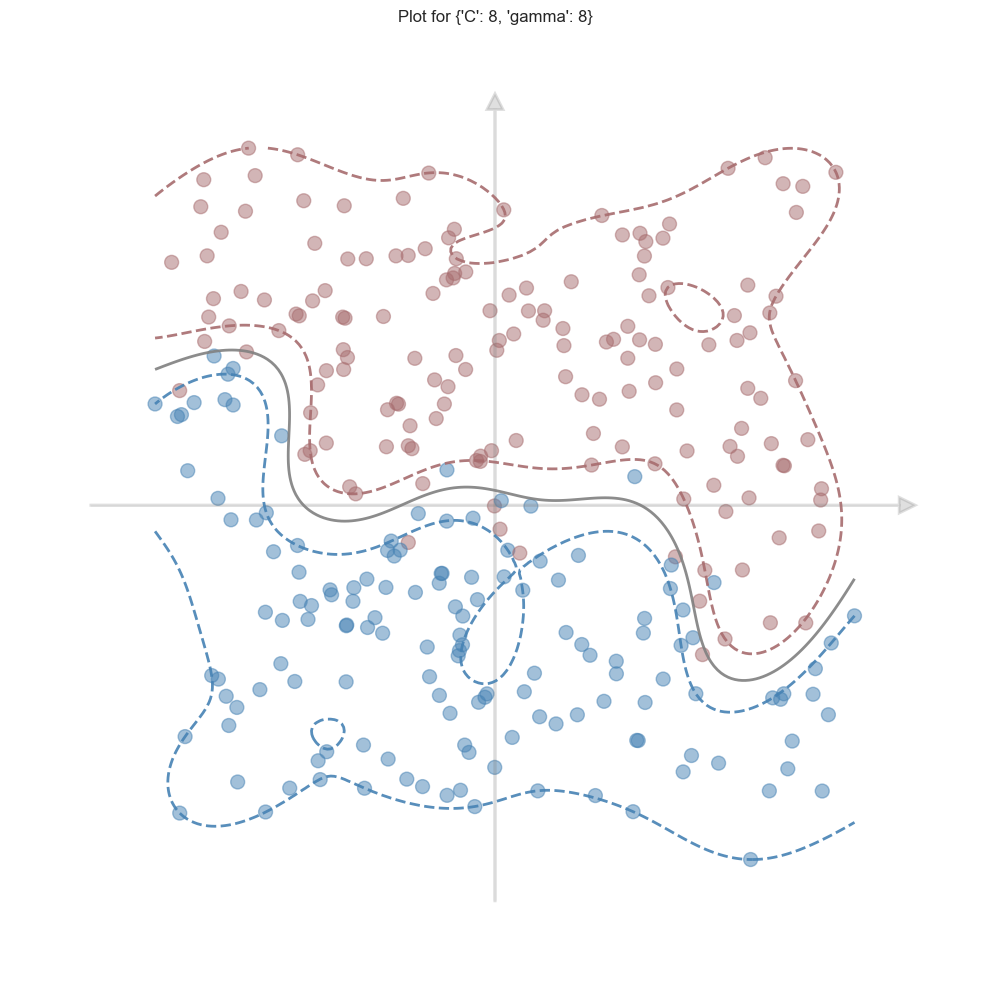

In [29]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

nlsvm = SVC(kernel='rbf')
param_range = [2 ** i for i in range(-5, 6)]
param_grid = {'C': param_range, 'gamma': param_range}

# in my first submission, I used the following line to define the CV
#       cv = KFold(n_splits=3, shuffle=True, random_state=42)
# but this is not necessary, since we're using cross_val_score, which does the CV for us.
# Also, I discovered it gives different results for grid.best_params_
# It shows the power of peer-review to assist our learning:

# updated version following code comparison with colleagues and setting cv = 3
grid = GridSearchCV(
    estimator=nlsvm,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X, y)
print("Best parameters = ", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

nonlinear_plot(X, y, grid.best_estimator_)
plt.title(f"Plot for {grid.best_params_}")
plt.tight_layout()
plt.show()


**Part B**: The following function will plot a heat-map of the cross-validation accuracies for each combination of parameters.  Which combination looks the best? Enter your response in this week's Peer Review assignment. 

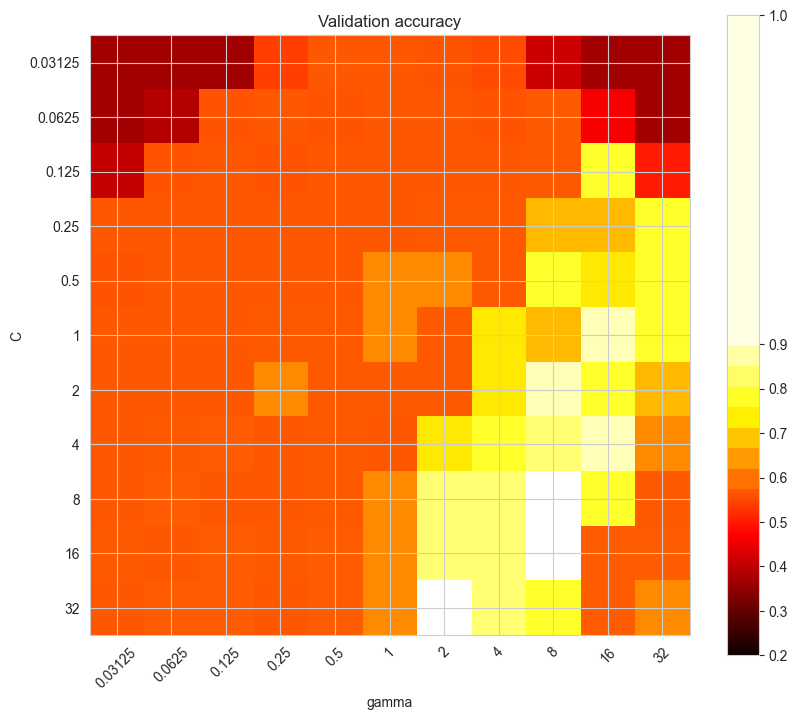

In [30]:
plotSearchGrid(grid)

In [31]:
# instuctor testing cell 
# your code here


**Part C**: The GridSearchCV object scores, among other things, the best combination of parameters as well as the cross-validation accuracy achieved with those parameters.  Print those quantities for our model. 

In [32]:
print("Best parameters = ", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)# print best paramters and best accuracy



Best parameters =  {'C': 8, 'gamma': 8}
Best Cross-Validation Accuracy: 0.9433333333333334


**Part D [Peer Review]**: The GridSearchCV object also stores the classifier trained with the best hyperparameters.  Pass this best estimator into the `nonlinear_plot` function to view the best decision boundary. Answer the Peer Review questions for this section. What can you tell about the best decision boundary? 

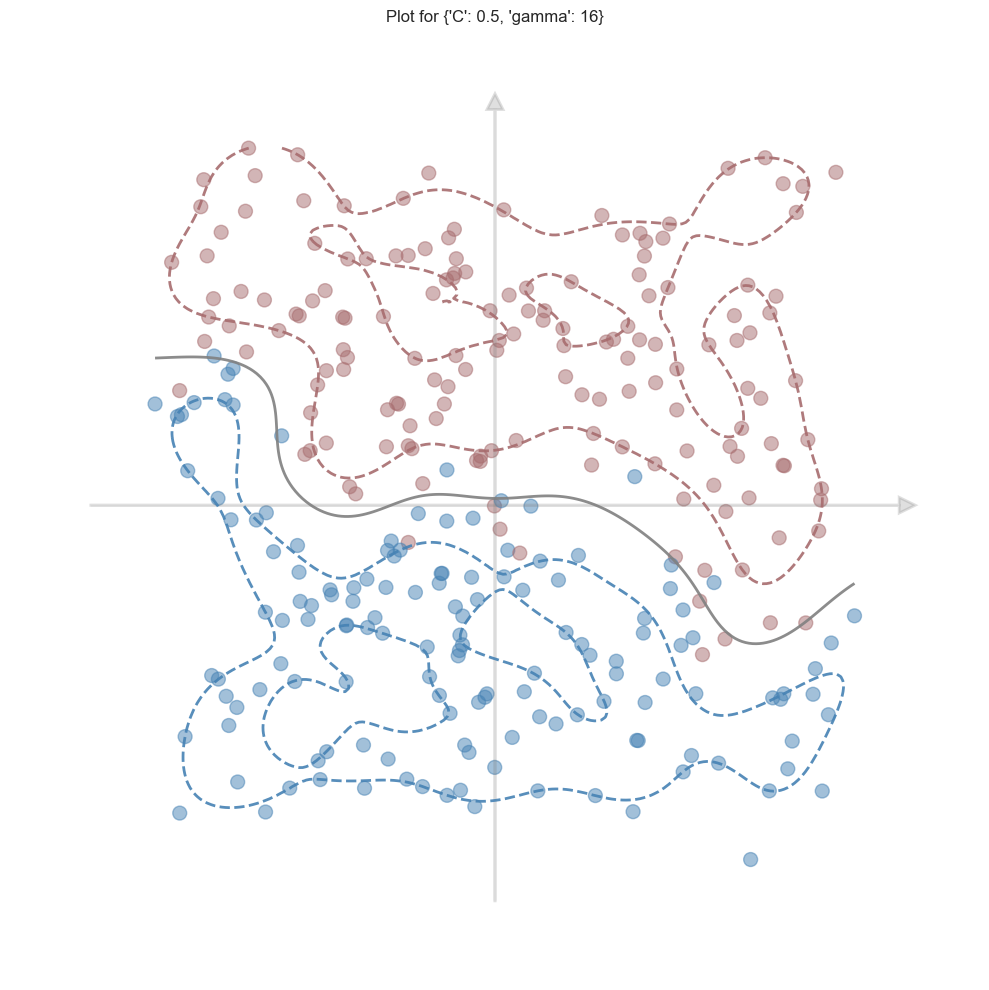

In [28]:
nonlinear_plot(X, y, grid.best_estimator_)
plt.title(f"Plot for {grid.best_params_}")
plt.tight_layout()
plt.show()
